Imports

In [166]:
import numpy
import scipy
import pandas
import matplotlib.pyplot as plt
import sklearn

Dataset for this week contains passenger information from Titanic disaster:

In [167]:
df = pandas.read_csv('titanic_train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


| Variable | Definition                                 | Key                                            |
|----------|--------------------------------------------|------------------------------------------------|
| survival | Survival                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 	1 = 1st, 2 = 2nd, 3 = 3rd                     |
| sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |
| parch    | # of parents / children aboard the Titanic |                                                |
| ticket   | Ticket number                              |                                                |
| fare     | Passenger fare                             |                                                |
| cabin    | Cabin number                               |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

Given a passenger's information, we'll predict the likelihood of survival, filtering out the unrelated columns and dropping rows with null values:

In [168]:
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin']
df = df.drop(columns=columns_to_drop).dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Sex       712 non-null    object 
 3   Age       712 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Embarked  712 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 44.5+ KB


Let's split the data and build the logistic regression model:

In [169]:
%%capture
# to suppress output of a cell, prepend %%capture
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# taking care of the categorical columns
columns_to_convert = []
df['Pclass'] = df['Pclass'].astype(str)
X = pandas.get_dummies(df.drop(columns='Survived'))
y = df['Survived']
# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=433)

model = LogisticRegression()
model.fit(X=X_train, y=y_train)

Fitted values of the coefficients:

In [170]:
coefficients = pandas.DataFrame(model.coef_.T, X.columns, columns=['Coefficient'])
print(f'Intercept: {model.intercept_}\tR2: {model.score(X, df.Survived)}')
coefficients

Intercept: [1.35857877]	R2: 0.8047752808988764


,Coefficient
Age,-0.038031
SibSp,-0.457478
Parch,0.033694
Pclass_1,1.096736
Pclass_2,0.022324
Pclass_3,-1.076971
Sex_female,1.302649
Sex_male,-1.260560
Embarked_C,0.455233
Embarked_Q,-0.377948


Remember that Survival column indicated survivors as 1, so higher coefficient values indicate higher chances of survival. R2 value is probably good for this type of analysis.

Accuracy of the model on test set:

In [171]:
model.score(X_test, y_test)

0.7914893617021277

Accuracy/R2 values of the train and test sets are close, so model will probably perform just as good on unseen data.

We can also use ROC curve as a measure of model performance, which compares it to a model that makes predictions at random, independent of the parameters:

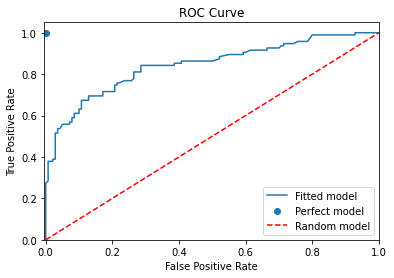

In [172]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label='Fitted model')
ax.scatter(0, 1, label='Perfect model')
ax.plot([0, 1], [0, 1],'r--', label='Random model')
ax.set_xlim([-0.005, 1])
ax.set_ylim([0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend(loc="lower right")

We can use logistic regression to predict categorical variables as well, let's predict the passenger class given the other variables:

In [173]:
%%capture --no-stdout
# Handling data
new_Y_columns = ['Pclass_1', 'Pclass_2', 'Pclass_3']
new_X = X.drop(columns=new_Y_columns)
new_X['Survived'] = y
# new_Y = X[new_Y_columns]
new_Y = df['Pclass'].to_numpy()
# Fitting model, we'll select multinomial as the multi_class
new_model = LogisticRegression(multi_class='multinomial')
new_model.fit(new_X, new_Y)
# reading the coefficients
coefficients = pandas.DataFrame(new_model.coef_.T, new_X.columns, columns=new_Y_columns)
print(f'Intercept: {new_model.intercept_}\tR2: {new_model.score(new_X, new_Y)}')
print(coefficients)

Intercept: [-1.36596859 -0.11357801  1.4795466 ]	R2: 0.6193820224719101
            Pclass_1  Pclass_2  Pclass_3
Age         0.049262 -0.005993 -0.043270
SibSp       0.167672 -0.079006 -0.088667
Parch       0.054089 -0.069015  0.014926
Sex_female -0.737519  0.083891  0.653627
Sex_male   -0.454535 -0.171807  0.626342
Embarked_C  0.416493 -0.262125 -0.154368
Embarked_Q -0.853719 -0.334829  1.188548
Embarked_S -0.754828  0.509039  0.245789
Survived    1.169077  0.033439 -1.202516


Let's check the model prediction for one of the passengers:

In [174]:
passenger = new_X[433:434]  # a trick to retain the column names, which are necessary for predict() and loc removes them
print(passenger)
prediction = new_model.predict(passenger)
prediction

      Age  SibSp  Parch  Sex_female  Sex_male  Embarked_C  Embarked_Q  \
546  19.0      1      0           1         0           0           0   

     Embarked_S  Survived  
546           1         1  


array(['2'], dtype=object)

So, for a surviving female passenger, aged 19 and embarked from Southampton, the model predicts the ticket as second class, which is correct since:

In [175]:
new_Y[433]

'2'